<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Deep%20Learning%20ANN/ANN_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

## **Import Data**

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [ ]:
df0 = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)
df0.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


**Get Starbucks Stocks for Dataset**

In [ ]:
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

**Log Transform**

In [ ]:
df['LogClose'] = np.log(df['Close'])

In [ ]:
df['DiffLogClose'] = df['LogClose'].diff()

In [ ]:
df.head()

,Close,LogClose,DiffLogClose,ScaledLogReturn,Diff ANN Train Prediction,Diff ANN Test Prediction,ShiftLogClose,1step_train,1step_test,multistep,multioutput
Date,,,,,,,,,,,
2010-01-04,11.525,2.444519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,11.795,2.467676,0.023157,1.474542,NaN,NaN,2.444519,NaN,NaN,NaN,NaN
2010-01-06,11.710,2.460443,-0.007233,-0.527921,NaN,NaN,2.467676,NaN,NaN,NaN,NaN
2010-01-07,11.680,2.457878,-0.002565,-0.220375,NaN,NaN,2.460443,NaN,NaN,NaN,NaN
2010-01-08,11.640,2.454447,-0.003431,-0.277396,NaN,NaN,2.457878,NaN,NaN,NaN,NaN


In [ ]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

We're going to do is `standardize the Time series`, as you can see, we're
doing this on the column `DiffLogClose`, which is really just the `LogReturn`.

So why do we want to standardize this data set?

Well, I want to avoid any in-depth mathematical details.

But usually in deep learning, `standardizing` or` normalizing` your data is a `good idea`. 
For intuition you can simply test this on various data sets.

What you should observe is that `standardization` seems to help more often than not.

In [ ]:
train['DiffLogClose']

Date
2010-01-04         NaN
2010-01-05    0.023157
2010-01-06   -0.007233
2010-01-07   -0.002565
2010-01-08   -0.003431
                ...   
2018-11-20   -0.010808
2018-11-21   -0.006122
2018-11-23   -0.016155
2018-11-26   -0.000152
2018-11-27    0.005919
Name: DiffLogClose, Length: 2242, dtype: float64

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

In [ ]:
train_scaled

array([[        nan],
       [ 1.47454198],
       [-0.5279206 ],
       ...,
       [-1.1158432 ],
       [-0.06137299],
       [ 0.33869831]])

In [ ]:
df['DiffLogClose']

Date
2010-01-04         NaN
2010-01-05    0.023157
2010-01-06   -0.007233
2010-01-07   -0.002565
2010-01-08   -0.003431
                ...   
2018-12-21   -0.012304
2018-12-24   -0.013612
2018-12-26    0.040769
2018-12-27    0.001901
2018-12-28    0.003002
Name: DiffLogClose, Length: 2263, dtype: float64

In [ ]:
train_scaled

array([[        nan],
       [ 1.47454198],
       [-0.5279206 ],
       ...,
       [-1.1158432 ],
       [-0.06137299],
       [ 0.33869831]])

In [ ]:
# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=2263, freq=None)

In [ ]:
train.index[-1]

Timestamp('2018-11-27 00:00:00')

In [ ]:
train_idx

array([False, False, False, ..., False, False, False])

In [ ]:
test_idx

array([False, False, False, ...,  True,  True,  True])

In [ ]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [ ]:
# Make supervised dataset
series = df['ScaledLogReturn'].dropna().to_numpy()
series

array([ 1.47454198, -0.5279206 , -0.22037511, ...,  2.63504571,
        0.07388234,  0.14644845])

In [ ]:
T = 10
x = []
y = []
for t in range(len(series) - T):
  X = series[t:t+T]
  x.append(X)
  Y = series[t+T]
  y.append(Y)

x = np.array(x).reshape(-1, T)
y = np.array(y)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (2252, 10) y.shape (2252,)


**Split Data**

In [ ]:
xtrain, ytrain = x[:-Ntest], y[:-Ntest]
xtest, ytest = x[-Ntest:], y[-Ntest:]

In [ ]:
# Basic ANN
i = Input(shape=(T,)) #input
x = Dense(32, activation='relu')(i) #hidden units 32 size
x = Dense(1)(x) #output
model = Model(i, x)

In [ ]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [ ]:
r = model.fit(
    xtrain,
    ytrain,
    epochs=200,
    validation_data =(xtest, ytest)
)

Epoch 1/200
70/70 [==============================] - 1s 5ms/step - loss: 1.2007 - val_loss: 1.0208
Epoch 2/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0575 - val_loss: 0.9873
Epoch 3/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0324 - val_loss: 0.9807
Epoch 4/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0160 - val_loss: 0.9870
Epoch 5/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0058 - val_loss: 0.9779
Epoch 6/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9959 - val_loss: 0.9783
Epoch 7/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9871 - val_loss: 0.9868
Epoch 8/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9807 - val_loss: 0.9754
Epoch 9/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9754 - val_loss: 0.9974
Epoch 10/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9711 - val_loss: 0.9977
Epoch 11/

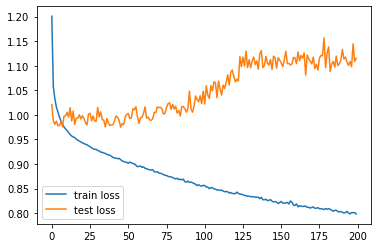

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

Notice how there is Overfitting, which we can observe by looking at the test loss.

In [ ]:
train_idx[:T+1] = False #first T+1 values are not predictable

Next step is to obtain the model predictions, so normally we would just call model predict, but recall that our data has been scaled.

Therefore we need to invert the scaling by calling scale or inverse transform.

In [ ]:
ptrain = model.predict(xtrain)
ptest = model.predict(xtest)

ptrain = scaler.inverse_transform(ptrain).flatten()
ptest = scaler.inverse_transform(ptest).flatten()

In [ ]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = ptest

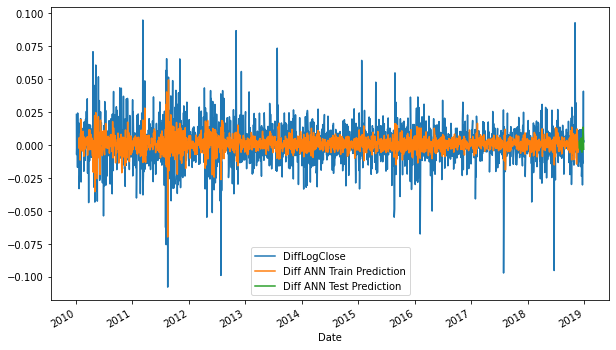

In [ ]:
cols = [
        'DiffLogClose',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction'
]
df[cols].plot(figsize=(10, 6))

Here's a plot of the one step stock return predictions.
Note that it's pretty difficult to see since there are so many values, so you might want to try just plotting the last few steps.


In [ ]:
df['ShiftLogClose'] = df['LogClose'].shift()
prev = df['ShiftLogClose']

In [ ]:
df.head()

,Close,LogClose,DiffLogClose,ScaledLogReturn,Diff ANN Train Prediction,Diff ANN Test Prediction,ShiftLogClose,1step_train,1step_test,multistep,multioutput
Date,,,,,,,,,,,
2010-01-04,11.525,2.444519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,11.795,2.467676,0.023157,1.474542,NaN,NaN,2.444519,NaN,NaN,NaN,NaN
2010-01-06,11.710,2.460443,-0.007233,-0.527921,NaN,NaN,2.467676,NaN,NaN,NaN,NaN
2010-01-07,11.680,2.457878,-0.002565,-0.220375,NaN,NaN,2.460443,NaN,NaN,NaN,NaN
2010-01-08,11.640,2.454447,-0.003431,-0.277396,NaN,NaN,2.457878,NaN,NaN,NaN,NaN


Next step is to save the last known train value, although we won't need this just yet

In [ ]:
# last-known train value
last_train = train.iloc[-1]['LogClose']

#### **1-Step Forecast**

Next step is to add the previous close price to the predicted returns, since this is just the 1-step forecast, we use the same method for both train and test

In [ ]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + ptest

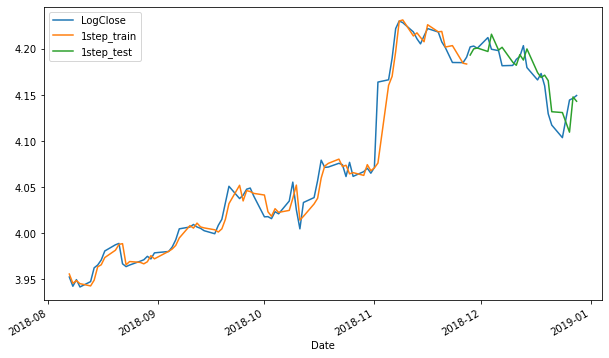

In [ ]:
# plot 1-step forecast
df.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize=(10, 6))

Here's a plot of the one step stock price predictions.
Notice how the model basically just lags the previous value, which is not unexpected

#### **Multi-Step Forecast**

In [ ]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

Next step is to invert the scaling on our predictions to do this, we're going to convert our list of predictions into a `numpy_array`.

We then reshape this to be two dimensional, which is required for scikit-learn.

And then after obtaining the un-scaled prediction, we flatten it back to a 1D Array

In [ ]:
# unscale
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(
    multistep_predictions.reshape(-1, 1)).flatten()

In [ ]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)
# np.cumsum = cumulative sum

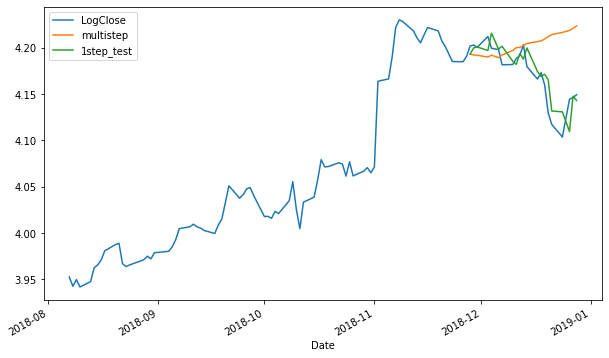

In [ ]:
# plot 1-step and multi-step forecast
df.iloc[-100:][['LogClose', 'multistep', '1step_test']].plot(figsize=(10, 6));

As you can see, it comes up to be almost a straight line with a trend, which makes sense, although it is not a good prediction.

#### Multi-output Forecast

In [ ]:
# Make multi-output supervised dataset
Tx = T
Ty = Ntest
x = []
y = []

for t in range(len(series) - Tx - Ty + 1):
  X = series[t:t+Tx]
  x.append(X)
  Y = series[t+Tx:t+Tx+Ty]
  y.append(Y)

x = np.array(x).reshape(-1, Tx)
y = np.array(y).reshape(-1, Ty)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (2232, 10) y.shape (2232, 21)


Next step is to split our new data into train and test. Recall that the test set is only the last row since that contains our entire forecast horizon

In [ ]:
xtrain_m, ytrain_m = x[:-1], y[:-1]
xtest_m, ytest_m = x[-1:], y[-1:]

In [ ]:
# Basic ANN
i = Input(shape=(Tx,)) #input
x = Dense(32, activation='relu')(i) #hidden units 32 size
x = Dense(Ty)(x) #output
model = Model(i, x)

In [ ]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [ ]:
r = model.fit(
    xtrain_m,
    ytrain_m,
    epochs=100,
    validation_data=(xtest_m, ytest_m)
)

Epoch 1/100
70/70 [==============================] - 1s 3ms/step - loss: 1.1321 - val_loss: 1.0284
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0588 - val_loss: 1.0414
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0339 - val_loss: 1.0370
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0212 - val_loss: 1.0405
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0134 - val_loss: 1.0348
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0083 - val_loss: 1.0300
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0046 - val_loss: 1.0324
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0017 - val_loss: 1.0248
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9994 - val_loss: 1.0219
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9976 - val_loss: 1.0167
Epoch 11/

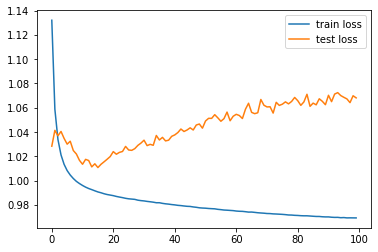

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

Notice that the plot is over overfit.

In [ ]:
ptrain = model.predict(xtrain)
ptest = model.predict(xtest)

In [ ]:
ptrain.shape, ptest.shape

((2231, 21), (21, 21))

In [ ]:
ptrain = ptrain[:,0]
ptest = ptest[0]

The main difference here is that we need to call inversed Transform to put our predictions back on the original scale.

In [ ]:
# unscale
ptest = scaler.inverse_transform(ptest.reshape(-1, 1)).flatten()

In [ ]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(ptest)

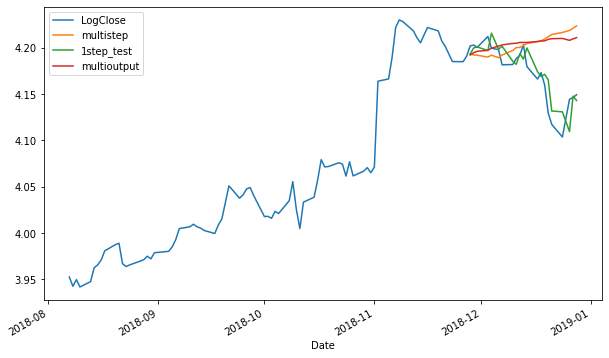

In [ ]:
# plot all forecast
cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(10, 6));

It's pretty much just a straight line with a small trend.

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print('multi-step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print('multi-output MAPE:', mape2)

multi-step MAPE: 0.008941029893924412
multi-output MAPE: 0.008424864019732883


## **1-Step Binary Classification**

Next step is to make our problems simpler by doing a one step binary classification.


So in order to build this data set, we can simply use what we had before.

We just need to make new targets by assigning anything above zero to one and anything below zero to zero.

In [ ]:
ytrain_b = (ytrain > 0) * 1
ytest_b = (ytest > 0) * 1

In [ ]:
#Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #binary classification
    optimizer = 'adam',
    metrics =['accuracy']
)

In [ ]:
r = model.fit(
    xtrain,
    ytrain_b,
    epochs=100,
    validation_data=(xtest, ytest_b)
)

Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 0.7516 - accuracy: 0.5016 - val_loss: 0.7012 - val_accuracy: 0.5238
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.5043 - val_loss: 0.7071 - val_accuracy: 0.5238
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.5034 - val_loss: 0.7045 - val_accuracy: 0.5238
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5043 - val_loss: 0.7067 - val_accuracy: 0.5238
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5074 - val_loss: 0.6991 - val_accuracy: 0.5238
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5047 - val_loss: 0.6981 - val_accuracy: 0.5238
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5065 - val_loss: 0.6951 - val_accuracy: 0.5238
Epoch 8/100
7

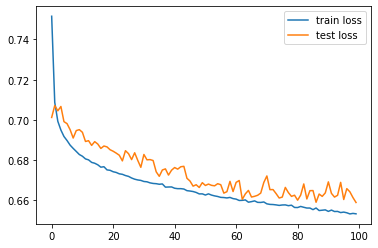

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

Test loss no longer increases

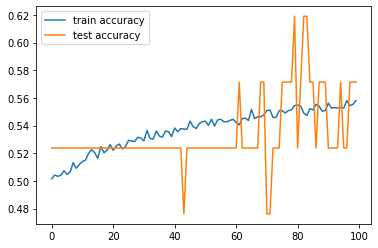

In [ ]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend();

So notice how even for the test set, which is quite small, we seem to do better than just predicting a random coin toss.

Of course, the real test is whether or not you can do this consistently.
